In [63]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import qgrid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### CCXT

In [64]:
polo = ccxt.poloniex({
    'apiKey': cfg.POLONIEX_API_KEY,
    'secret': cfg.POLONIEX_API_SECRET_KEY,
})
gdax = ccxt.gdax({
    'apiKey': cfg.GDAX_API_KEY,
    'secret': cfg.GDAX_API_SECRET_KEY,
    'password': cfg.GDAX_PASSPHRASE,
    'verbose':False,
})
binance = ccxt.binance()

exchange = binance
markets = exchange.load_markets()

#print(exchange.id, markets)
#print(exchange.fetch_order_book(exchange.symbols[0]))
#print(exchange.fetch_ticker('ETH/BTC')) # coin/market - base/quote
#print(exchange.fetch_trades('LTC/BTC'))

### Ingest Data

In [65]:
# Get historical data
coins = [c.BTC, c.ETH, c.LTC]#, c.ETH, c.XRP, c.XMR, c.DASH]
market = c.USDT
coin = c.LTC
symbol = ohlcv.get_symbol(coin, market)
period = '1m' #1800
#start = datetime.datetime(year=2018, month=1, day=4, hour=14)
start = datetime.datetime.utcnow() - datetime.timedelta(hours=2)
end = datetime.datetime.utcnow() - datetime.timedelta(hours=0)

In [66]:
# Single Coin
df = ohlcv.fetch_and_save_ohlcv_data(exchange, coin, market, period, start, end)
df.head()

Downloading: LTC/USDT
Downloaded rows: 120


,open,high,low,close,volume,time_utc
time_epoch,,,,,,
1515193620,238.11,239.19,238.00,238.99,13.82443,2018-01-05 23:07:00
1515193680,238.86,238.99,238.70,238.94,12.77529,2018-01-05 23:08:00
1515193740,238.94,239.43,238.90,239.43,28.70739,2018-01-05 23:09:00
1515193800,239.61,241.28,239.29,240.53,55.46923,2018-01-05 23:10:00
1515193860,239.73,240.53,239.73,239.73,4.58759,2018-01-05 23:11:00


In [44]:
df.iloc[0]['time_utc']

Timestamp('2018-01-05 23:00:00')

In [68]:
fpath = ohlcv.get_price_data_fpath(coin, market, exchange.id, period)

In [69]:
df = ohlcv.load_chart_data_from_file(fpath)

In [72]:
# Multiple Coins
ohlcv.download_chart_data(exchange, coins, market, period, start, end)
df = ohlcv.load_multi_coin_data(exchange.id, coins, market, period, start)
df.head()

Downloading: BTC/USDT
Downloaded rows: 120
Downloading: ETH/USDT
Downloaded rows: 120
Downloading: LTC/USDT
Downloaded rows: 120


,BTC/USDT,ETH/USDT,LTC/USDT,time_utc
time_epoch,,,,
1515193620,16961.10,937.97,238.99,2018-01-05 23:07:00
1515193680,17000.00,937.90,238.94,2018-01-05 23:08:00
1515193740,17000.24,937.65,239.43,2018-01-05 23:09:00
1515193800,17052.99,937.03,240.53,2018-01-05 23:10:00
1515193860,17040.00,938.46,239.73,2018-01-05 23:11:00


In [73]:
df.iloc[0]['time_utc']

Timestamp('2018-01-05 23:07:00')

### Feeds

In [74]:
# CSV Feed
feed_fpath = ohlcv.get_price_data_fpath(coin=c.LTC, market=c.USDT, exchange_id=exchange.id, period='1m')
feed = CSVDataFeed(feed_fpath)
feed.initialize()

Loading feed: data/binance_LTC_USDT_1m.csv
START 0001-01-01 01:01:00
PRIOR 0001-01-01 01:00:00


In [78]:
# Grab 1 row at a time
for i in range(3):
    data = feed.next()
    print(data['time_utc'], data['close'])

2018-01-05 23:16:00 241.51
2018-01-05 23:17:00 242.0
2018-01-05 23:18:00 242.23


In [80]:
# Access all rows in history
feed.history().head()

,open,high,low,close,volume,time_utc
time_epoch,,,,,,
1515193620,238.11,239.19,238.00,238.99,13.82443,2018-01-05 23:07:00
1515193680,238.86,238.99,238.70,238.94,12.77529,2018-01-05 23:08:00
1515193740,238.94,239.43,238.90,239.43,28.70739,2018-01-05 23:09:00
1515193800,239.61,241.28,239.29,240.53,55.46923,2018-01-05 23:10:00
1515193860,239.73,240.53,239.73,239.73,4.58759,2018-01-05 23:11:00


In [81]:
# Exchange Live Feed

coins = [c.ETH, c.XRP, c.XMR]
market = c.BTC
period = '1m'
start = datetime.datetime.utcnow() - datetime.timedelta(hours=1)
end = None
feed_fpath = ohlcv.get_price_data_fpath(coins[2], market, exchange.id, period)

In [82]:
feed = ExchangeDataFeed(exchange, [coins[2]], market, period, feed_fpath, start, end)
feed.initialize()

Loading feed: data/binance_XMR_BTC_1m.csv
START 2018-01-06 00:07:33.470649
PRIOR 2018-01-06 00:06:33.470649
Downloading: XMR/BTC
Downloaded rows: 61


In [83]:
# Access History
feed.history(t_minus=3).tail()

,open,high,low,close,volume,time_utc
time_epoch,,,,,,
1515200700,0.020889,0.020890,0.020816,0.020876,53.298,2018-01-06 01:05:00
1515200760,0.020891,0.020891,0.020813,0.020890,2.994,2018-01-06 01:06:00
1515200820,0.020890,0.020890,0.020843,0.020843,0.281,2018-01-06 01:07:00


In [87]:
# Grab 1 row at a time (don't refresh data)
for i in range(3):
    data = feed.next(refresh=False)
    print(data['time_utc'], data['close'])

2018-01-06 00:17:00 0.021303
2018-01-06 00:18:00 0.021308
2018-01-06 00:19:00 0.021401


In [88]:
# Refresh data before next query
data = feed.next(refresh=True)
print(data['time_utc'], data['close'])

Downloading: XMR/BTC
Downloaded rows: 50
2018-01-06 00:20:00 0.021416


In [89]:
# Example Using the Feed

def my_strategy(row, history, exchange):
    print("Time:", row['time_utc'], "Price:", row['close'])
    if row['close'] > .024:
        print("Buying coin")
        #res = exchange.limit_buy(quantity=1, price=5)
    else:
        print("Selling that stupid coin")
    return {
        'time': row['time_utc'],
        'close': row['close'],
        'action': 'buy',
        'quantity': 1,
        'price': 5,
        'exchange': exchange.id
    }

def backtest(feed, strategy, exchange):
    results = []
    row = feed.next()
    while row is not None:
        output = strategy(row, feed, exchange)
        row = feed.next(refresh=True)
        results.append(output)
    return results

In [90]:
res = backtest(feed, my_strategy, exchange)

Time: 2018-01-06 00:21:00 Price: 0.02141
Selling that stupid coin
Downloading: XMR/BTC
Downloaded rows: 48
Time: 2018-01-06 00:22:00 Price: 0.021415
Selling that stupid coin
Downloading: XMR/BTC
Downloaded rows: 47
Time: 2018-01-06 00:23:00 Price: 0.021311
Selling that stupid coin
Downloading: XMR/BTC
Downloaded rows: 46
Time: 2018-01-06 00:24:00 Price: 0.021448
Selling that stupid coin
Downloading: XMR/BTC
Downloaded rows: 45
Time: 2018-01-06 00:25:00 Price: 0.021451
Selling that stupid coin
Downloading: XMR/BTC
Downloaded rows: 44
Time: 2018-01-06 00:26:00 Price: 0.021509
Selling that stupid coin
Downloading: XMR/BTC
Downloaded rows: 43
Time: 2018-01-06 00:27:00 Price: 0.021482
Selling that stupid coin
Downloading: XMR/BTC
Downloaded rows: 42
Time: 2018-01-06 00:28:00 Price: 0.021594
Selling that stupid coin
Downloading: XMR/BTC
Downloaded rows: 41
Time: 2018-01-06 00:29:00 Price: 0.021308
Selling that stupid coin
Downloading: XMR/BTC
Downloaded rows: 40
Time: 2018-01-06 00:30:00 Pri

### Order

In [91]:
order = Order(
    ex_id=exchange.id, 
    coin=c.LTC,
    market=c.USDT,
    price=250., 
    quantity=1, order_type=OrderType.BUY_LIMIT
)
order.set_status(OrderStatus.OPEN)
order

{'order_id': 'OD1D35443E6BDF', 'exchange_order_id': None, 'exchange_id': 'binance', 'coin': 'LTC', 'market': 'USDT', 'price': 250.0, 'quantity': 1, 'order_type': <OrderType.BUY_LIMIT: 0>, 'order_status': <OrderStatus.OPEN: 2>, 'created_time': datetime.datetime(2018, 1, 6, 1, 8, 38, 65852), 'opened_time': None, 'filled_time': None, 'canceled_time': None, 'retries': 0}

In [92]:
order_json = order.to_json()
load_order_from_json(order_json)

{'order_id': 'OD1D35443E6BDF', 'exchange_order_id': None, 'exchange_id': 'binance', 'coin': 'LTC', 'market': 'USDT', 'price': 250.0, 'quantity': 1, 'order_type': <OrderType.BUY_LIMIT: 0>, 'order_status': <OrderStatus.OPEN: 2>, 'created_time': datetime.datetime(2018, 1, 6, 1, 8, 38, 65852), 'opened_time': None, 'filled_time': None, 'canceled_time': None, 'retries': 0}

### Strategy

In [93]:
# https://www.backtrader.com/docu/quickstart/quickstart.html
# https://enigmampc.github.io/catalyst/beginner-tutorial.html#basics

class Strategy():
    def __init__(self, context):
        self.ctx = context
        self.initialize()
    
    def initialize(self):
        self.ctx.symbol = 'BTC/USD'
    
    def handle_data(self, data):
        # Handle next iteration of data from feed
        pass
    
class TestStrategy():
    def __init__(self):
        pass
    
    def next(self, data):
        pass

### Plotting

AttributeError: 'numpy.ndarray' object has no attribute 'find'

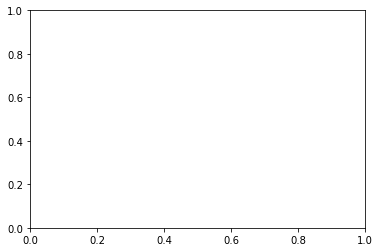

In [94]:
utils.charts.plot_range(feed.history(), start, end, 'close')

### Exchange

In [ ]:
# https://github.com/ccxt/ccxt/blob/master/python/ccxt/base/exchange.py

class Exchange():
    def __init__(self):
        pass

class CCXTExchange(Exchange):
    def __init__(self, exchange_client):
        self.ex = exchange_client
        
    def fetch_balance(self):
        return self.ex.fetch_balance()
    
    def limit_buy(self, symbol, quantity, price):
        return self.ex.create_limit_buy_order(symbol, quantity, price)
    

class TestExchange(Exchange):
    def __init__(self):
        self.orders = {'BTC/USD':[]}
        self.trades = {}
        self.fees = {'trading': .025, 'funding': .025}
        self.balance = {
            'BTC': {'free': 0.0, 'total': 0.0, 'used': 0.0},
            'USD': {'free': 0.6, 'total': 0.6, 'used': 0.0},
            'free': {'BCH': 0.0, 'BTC': 0.6, 'ETH': 0.0, 'LTC': 0.0, 'USD': 486.3}
        }
    
    def fetch_balance(self):
        return self.balance
    
    def limit_buy(self, coin, market, quantity, price):
        symbol = ohlcv.get_symbol(coin, market)
        self.orders[symbol].append("NEW_ORDER")
        
        # We assume the order goes through
        self.balance[market]['free'] -= quantity * price
        self.balance[coin]['used'] += quantity * price
        
        # Account for fees here
        self.balance[market]['total'] -= self.fees['trading']
        return self.orders

In [ ]:
ex = TestExchange()
print(ex.fetch_balance())
orders = ex.limit_buy(c.BTC, c.USD, 1, 15000.0)
orders

In [ ]:
EX = Exchange(gdax)

### Runner

In [ ]:
from enum import Enum, unique

@unique
class TradeMode(Enum):
    BACKTEST = 0
    SIMULATE = 1
    LIVE = 2

class Punisher():
    def __init__(self, exchange, feed, strategy, record):
        self.exchange = exchange
        self.feed = feed
        self.strategy = strategy
        self.record = {
            'test': [],
            'live': []
        }
        
    def backtest(self):
        results = []
        row = feed.next()
        while row is not None:
            print("Timestep", row['time_utc'], "Price", row['close'])
            row = feed.next()
            output = self.strategy(row, exchange, feed)
            results.append(output)
        return results
    
    def simulate(self):
        while True:
            row = feed.next()
            if row is not None:
                output = self.strategy(row, exchange, feed)
                self.record['test'].append(output)
            time.sleep(2)

    def live(self):
        while True:
            row = feed.next()
            if row is not None:
                output = self.strategy(row, exchange, feed)
                self.record['live'].append(output)
            time.sleep(2)
    
    def punish(self, mode=False):
        if mode == TradeMode.BACKTEST:
            print("Backtesting ...")
            self.backtest()
        elif mode == TradeMode.SIMULATE:
            print("Simulating orders ...")
            self.simulate()
        elif mode == TradeMode.LIVE:
            print("LIVE TRADING! CAREFUL!")
            self.live()

### Trading

In [ ]:
# Trading
print(exchange.fetch_balance())

# sell one ฿ for market price and receive $ right now
print(exchange.id, exchange.create_market_sell_order('BTC/USD', 1))

# limit buy BTC/EUR, you pay €2500 and receive ฿1  when the order is closed
print(exchange.id, exchange.create_limit_buy_order('BTC/EUR', 1, 2500.00))

# pass/redefine custom exchange-specific order params: type, amount, price, flags, etc...
polo.create_market_buy_order('BTC/USD', 1, {'trading_agreement': 'agree'})